In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.pipeline import Pipeline, make_pipeline

In [37]:
df = pd.read_csv('../../data/cars/cars.csv')

## Default cleaning

In [38]:
# I assume that the relationships between card brands and types are different and can't be captured by a single model
df = df.drop_duplicates()
df = df.query('Make == "Volkswagen"')
df = df[df['Model'].str.contains('Golf')]
df = df[df['Model'].isin(['Golf', 'Golf GTI', 'Golf Variant', 'Golf GTE', 'Golf Plus'])]

## Train test split

In [39]:
train, validation = train_test_split(df, test_size=0.25, random_state=42)  

## Cleaning

In [40]:
def clean_data(df):
    df = df.copy()

    # Feature names
    # Convert to dates
    date_features = ['Production_Date', 'Build_Year', 'Technical_Inspection', 'Last_Service']
    for feature in date_features:
        df[feature] = pd.to_datetime(df[feature], format='mixed')

    # Engine_Displacement
    def fix_engine_displacement(row):
        if row['Engine_Displacement'] > 10:
            return row['Engine_Displacement'] / 1000
        return row['Engine_Displacement']
    # Remove other energy
    df['Engine_Displacement'] = df.apply(fix_engine_displacement, axis=1)

    # Fuel Electric -> drop
    df = df[df['Fuel'] != 'Electric']

    # Category
    df['Category'] = df['Category'].replace(
        {'New Registered': "New", 
        'Classic': "Used", 
        'Demo': "Used", 
    })

    # Doors
    df['Doors'] = df['Doors'].replace(
        {2: 3, 
        4: 5, 
    })  

    # Rare Body types: Remove
    rare_body_types = ['SUV/Off-Road/Pick-Up', 'Overig', 'Cabrio', 'Sedan']
    df = df[~df['Body_Type'].isin(rare_body_types)]

    # Drive_Type: missing -> Front
    df['Drive_Type'] = df['Drive_Type'].replace(np.nan, 'Front')

    # Transmission: Semi-automatic -> Automatic
    df['Transmission'] = df['Transmission'].replace('Semi-automatic', 'Automatic')

    current_date = pd.to_datetime('2025-07-01')
    df['Age_Months'] = (current_date.year - df['Production_Date'].dt.year) * 12 + (current_date.month - df['Production_Date'].dt.month)

    del df['Make']
    del df['Seats']
    del df['Non_Smoker_Car']
    del df['Warranty']
    del df['Last_Service']
    del df['Electric_Range']
    del df['Other_Energy_Sources']
    del df['Production_Year']
    del df['Build_Year']
    del df['Technical_Inspection']
    del df['Production_Date']

    categorical_features = ['Model', 'Color', 'Body_Type', 'Drive_Type',
       'Transmission', 'Emission_Class', 'Fuel', 'Category',
       'Interior_Material', 'Interior_Color', 'Paint_Type', 'Doors']
    
    # Convert to categorical
    for feature in categorical_features:
        df[feature] = df[feature].astype('category')

    return df

In [41]:
train_clean = clean_data(train)
validation_clean = clean_data(validation)

In [42]:
categorical_features = train_clean.select_dtypes(include=['category']).columns.tolist()
numerical_features = [f for f in train_clean.columns if f not in categorical_features + ['Price']]

In [43]:
X_train, y_train = train_clean[numerical_features + categorical_features], train_clean['Price']
X_validation, y_validation = validation_clean[numerical_features + categorical_features], validation_clean['Price']

## Score to beat

In [44]:
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))

0.9198140350541666 0.8939404218299793


## Some visualisation

Text(0, 0.5, 'Feature')

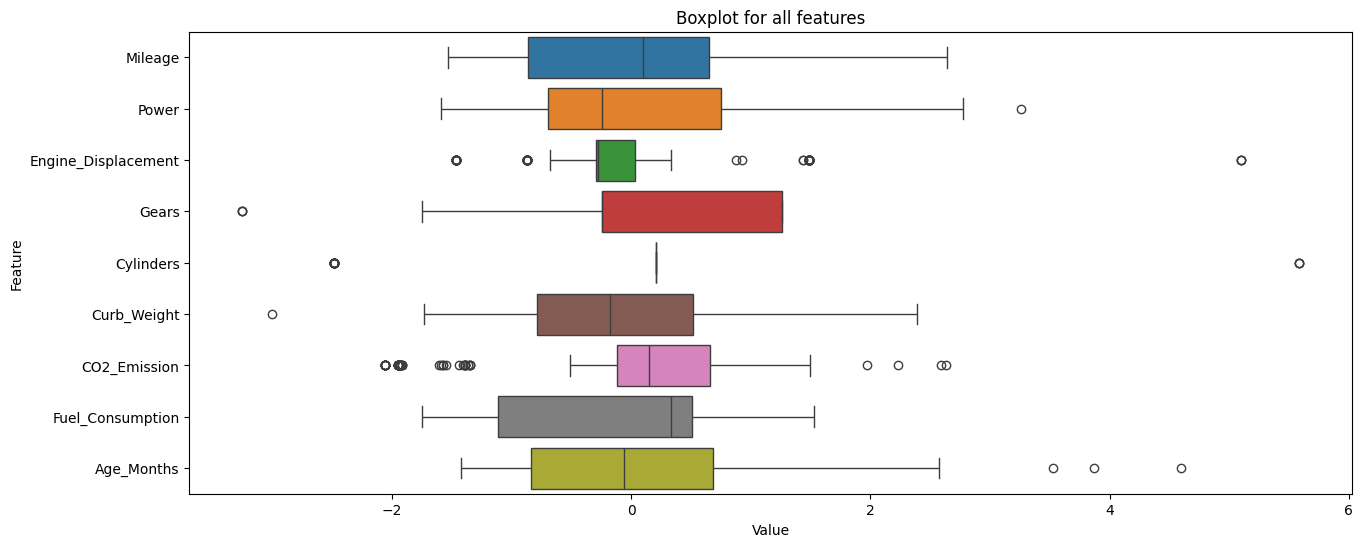

In [51]:
scaler = StandardScaler()
X_train_scaled_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),
                              columns=numerical_features,
                              index=X_train.index)

plt.figure(figsize=(15,6))
sns.boxplot(data=X_train_scaled_numerical, orient='h')
plt.title("Boxplot for all features")
plt.xlabel("Value")
plt.ylabel("Feature")

Text(0, 0.5, 'Feature')

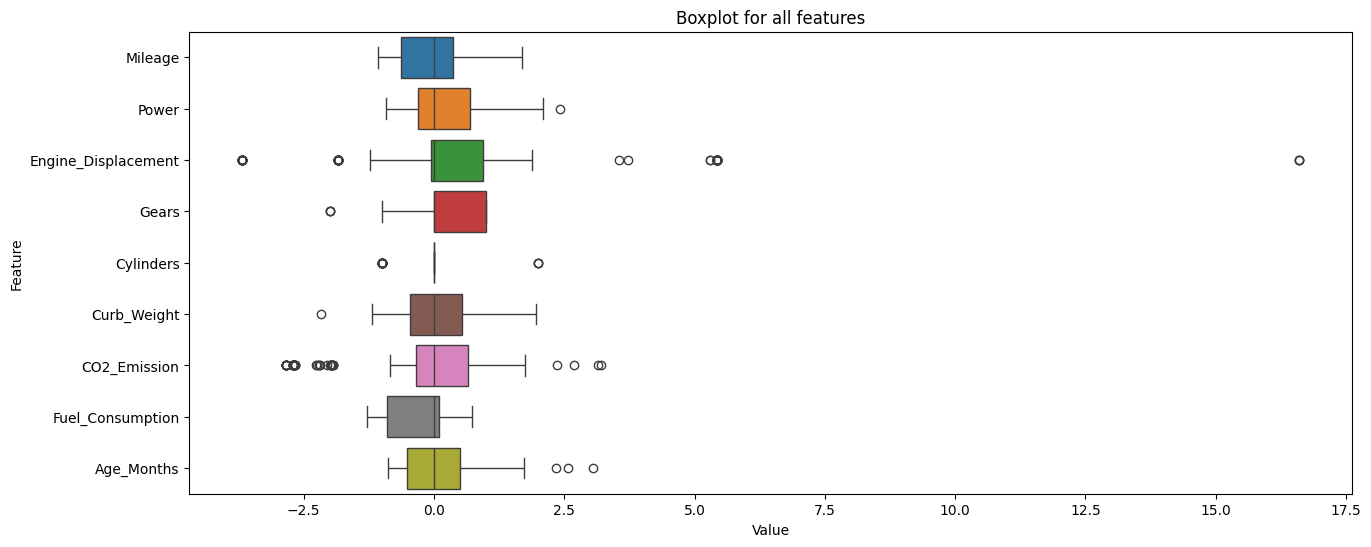

In [11]:
scaler = RobustScaler()
X_train_scaled_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),
                              columns=numerical_features,
                              index=X_train.index)

plt.figure(figsize=(15,6))
sns.boxplot(data=X_train_scaled_numerical, orient='h')
plt.title("Boxplot for all features")
plt.xlabel("Value")
plt.ylabel("Feature")

In [55]:
X_train_scaled_numerical.corrwith(y_train).abs().sort_values()

Cylinders              0.068688
Engine_Displacement    0.307978
CO2_Emission           0.435583
Gears                  0.468224
Fuel_Consumption       0.571675
Curb_Weight            0.605998
Power                  0.681903
Age_Months             0.803106
Mileage                0.816589
dtype: float64

Text(0, 0.5, 'Residuals')

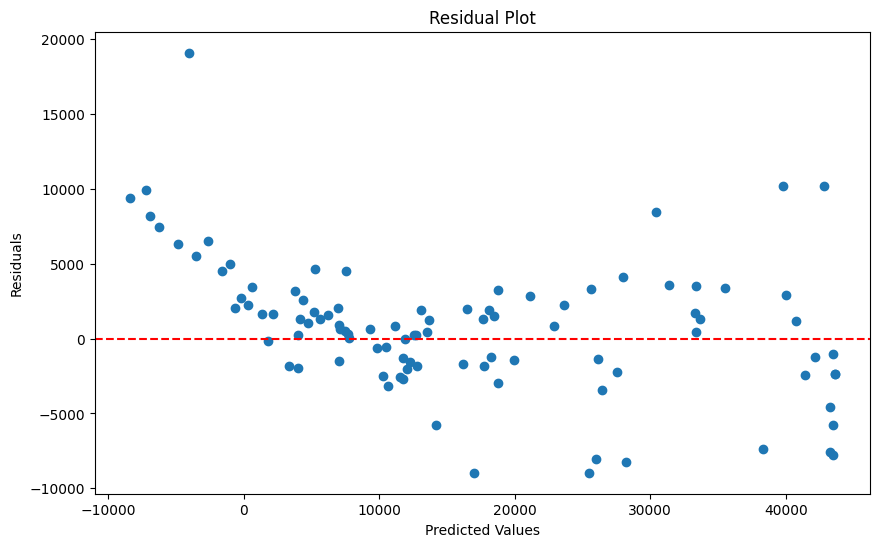

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train, y_train)

# Residual plot
y_pred = pipeline.predict(X_validation)
residuals = y_validation - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")


## Outlier removal with z-scores

In [ ]:
# Remove outliers with z-scores sigma > 3
z_scores = np.abs((X_train[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std())
outliers = (z_scores > 3).any(axis=1)
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train_no_outliers, y_train_no_outliers)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))

0.9195070455100771 0.8956627299158675


## Outlier removal with Mahalanobis

In [61]:
# Now the same but with mahalanobis from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import EmpiricalCovariance

X_train_simple_fill = X_train[numerical_features].fillna(X_train[numerical_features].mean())
mahal = EmpiricalCovariance()
mahal.fit(X_train_simple_fill)
mahal_dist = mahal.mahalanobis(X_train_simple_fill)
outliers = mahal_dist > np.percentile(mahal_dist, 99)
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train_no_outliers, y_train_no_outliers)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))


0.921119447368284 0.8974171067866121


## Outlier removal with Isolation forest

In [15]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)

X_train_simple_fill = X_train[numerical_features].fillna(X_train[numerical_features].mean())
iso_forest.fit(X_train_simple_fill)
outliers = iso_forest.predict(X_train_simple_fill) == -1
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
    ('model', model)
])

pipeline.fit(X_train_no_outliers, y_train_no_outliers)

print(pipeline.score(X_train, y_train),
    pipeline.score(X_validation, y_validation))


0.9179033310018127 0.8943763442576963


In [ ]:
model = LinearRegression()

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
        ]), numerical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42)),
])

pipeline.fit(X_train, y_train)

X_train_processed = pipeline.transform(X_train)


In [17]:
# Now after the processing step
iso_forest = IsolationForest(contamination=0.01, random_state=42)

iso_forest.fit(X_train_processed)

outliers = iso_forest.predict(X_train_processed) == -1
X_train_processed_no_outliers = X_train_processed[~outliers]
y_train_no_outliers = y_train[~outliers]
X_validation_processed = pipeline.transform(X_validation)

model = LinearRegression()

model.fit(X_train_processed_no_outliers, y_train_no_outliers)
print(model.score(X_train_processed_no_outliers, y_train_no_outliers),
    model.score(X_validation_processed, y_validation))

0.9183056856713342 0.8823436756987736


### Semi-supervised

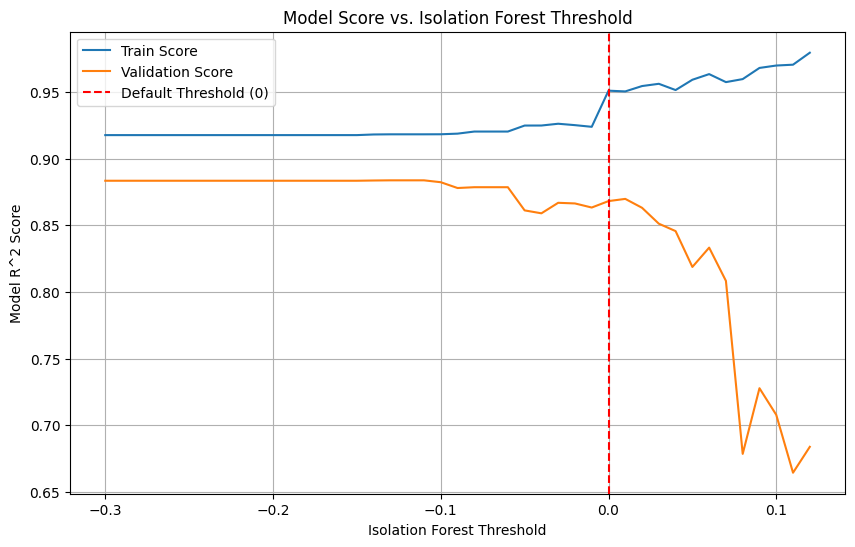

In [18]:
iso_forest = IsolationForest(random_state=42)

iso_forest.fit(X_train_processed)

scores = iso_forest.decision_function(X_train_processed)

# Test different thresholds (from -2 to 2 in steps of 0.1)
thresholds = np.arange(-.3, .3, 0.01)
train_scores = []
validation_scores = []
for threshold in thresholds:
    outliers = scores < threshold
    X_train_processed_no_outliers = X_train_processed[~outliers]
    if X_train_processed_no_outliers.shape[0] < 10:
        train_scores.append(np.nan)
        validation_scores.append(np.nan)
        continue

    y_train_no_outliers = y_train[~outliers]
    X_validation_processed = pipeline.transform(X_validation)

    model = LinearRegression()
    model.fit(X_train_processed_no_outliers, y_train_no_outliers)
    train_scores.append(model.score(X_train_processed_no_outliers, y_train_no_outliers))
    validation_scores.append(model.score(X_validation_processed, y_validation))

plt.figure(figsize=(10,6))
plt.plot(thresholds, train_scores, label='Train Score')
plt.plot(thresholds, validation_scores, label='Validation Score')
plt.axvline(0, color='red', linestyle='--', label='Default Threshold (0)')
plt.title("Model Score vs. Isolation Forest Threshold")
plt.xlabel("Isolation Forest Threshold")
plt.ylabel("Model R^2 Score")
plt.legend()
plt.grid()

### Checking with different train validation splits

In [28]:
results = []
thresholds = np.arange(-.3, .3, 0.01)

for seed in range(10):
    train, validation = train_test_split(df, test_size=0.25, random_state=seed)  

    train_clean = clean_data(train)
    validation_clean = clean_data(validation)

    X_train, y_train = train_clean[numerical_features + categorical_features], train_clean['Price']
    X_validation, y_validation = validation_clean[numerical_features + categorical_features], validation_clean['Price']

    model = LinearRegression()

    preprocessing = ColumnTransformer(
        transformers=[
            ('cat', Pipeline(steps=[
                ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
            ]), categorical_features),
            ('num', Pipeline(steps=[
                ('scaler', StandardScaler()),
            ]), numerical_features),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42))
    ])

    pipeline.fit(X_train, y_train)

    X_train_processed = pipeline.transform(X_train)
    X_validation_processed = pipeline.transform(X_validation)

    iso_forest = IsolationForest(random_state=42)

    iso_forest.fit(X_train_processed)

    scores = iso_forest.decision_function(X_train_processed)

    for threshold in thresholds:
        outliers = scores < threshold
        X_train_processed_no_outliers = X_train_processed[~outliers]
        if X_train_processed_no_outliers.shape[0] < 10:
            train_scores.append(np.nan)
            validation_scores.append(np.nan)
            continue

        y_train_no_outliers = y_train[~outliers]

        model = LinearRegression()
        model.fit(X_train_processed_no_outliers, y_train_no_outliers)
        results.append({
            'train': model.score(X_train_processed_no_outliers, y_train_no_outliers),
            'val': model.score(X_validation_processed, y_validation),
            'threshold': threshold,
            'seed': seed
        })

(-0.2, 0.1515000000000004)

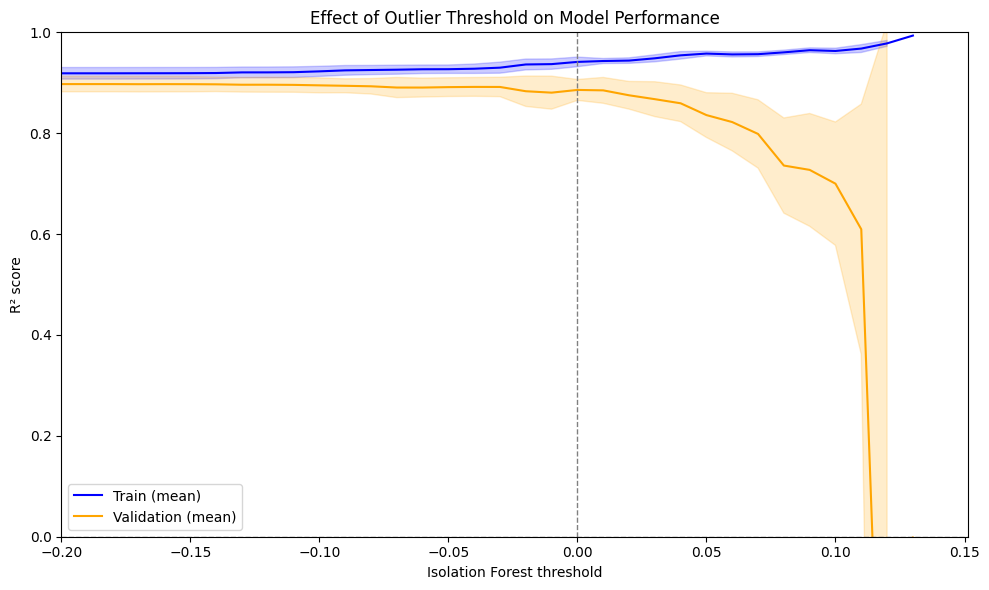

In [30]:

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Average across seeds for each threshold
mean_scores = df_results.groupby("threshold")[["train", "val"]].mean().reset_index()
std_scores = df_results.groupby("threshold")[["train", "val"]].std().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_scores["threshold"], mean_scores["train"], label="Train (mean)", color="blue")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["train"] - std_scores["train"],
                 mean_scores["train"] + std_scores["train"],
                 alpha=0.2, color="blue")

plt.plot(mean_scores["threshold"], mean_scores["val"], label="Validation (mean)", color="orange")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["val"] - std_scores["val"],
                 mean_scores["val"] + std_scores["val"],
                 alpha=0.2, color="orange")

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Isolation Forest threshold")
plt.ylabel("R² score")
plt.title("Effect of Outlier Threshold on Model Performance")
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.xlim(-0.2, None)

## Outlier removal on select features

In [68]:
X_train[numerical_features].corrwith(y_train).abs().sort_values(ascending=False)

Mileage                0.816589
Age_Months             0.803106
Power                  0.681903
Curb_Weight            0.605998
Fuel_Consumption       0.571675
Gears                  0.468224
CO2_Emission           0.435583
Engine_Displacement    0.307978
Cylinders              0.068688
dtype: float64

In [78]:
results = []
thresholds = np.arange(-.3, .3, 0.01)
useful_features = [f'num__{f}' for f in ['Mileage', 'Age_Months']]

for seed in range(10):
    train, validation = train_test_split(df, test_size=0.25, random_state=seed)  

    train_clean = clean_data(train)
    validation_clean = clean_data(validation)

    X_train, y_train = train_clean[numerical_features + categorical_features], train_clean['Price']
    X_validation, y_validation = validation_clean[numerical_features + categorical_features], validation_clean['Price']

    model = LinearRegression()

    preprocessing = ColumnTransformer(
        transformers=[
            ('cat', Pipeline(steps=[
                ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
            ]), categorical_features),
            ('num', Pipeline(steps=[
                ('scaler', StandardScaler()),
            ]), numerical_features),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42))
    ])

    pipeline.fit(X_train, y_train)

    X_train_processed = pd.DataFrame(pipeline.transform(X_train), columns=pipeline.get_feature_names_out())
    X_validation_processed = pd.DataFrame(pipeline.transform(X_validation), columns=pipeline.get_feature_names_out())

    iso_forest = IsolationForest(random_state=42)

    iso_forest.fit(X_train_processed[useful_features])

    scores = iso_forest.decision_function(X_train_processed[useful_features])

    for threshold in thresholds:
        outliers = scores < threshold
        X_train_processed_no_outliers = X_train_processed[~outliers]
        if X_train_processed_no_outliers.shape[0] < 10:
            train_scores.append(np.nan)
            validation_scores.append(np.nan)
            continue

        y_train_no_outliers = y_train[~outliers]

        model = LinearRegression()
        model.fit(X_train_processed_no_outliers, y_train_no_outliers)
        results.append({
            'train': model.score(X_train_processed_no_outliers, y_train_no_outliers),
            'val': model.score(X_validation_processed, y_validation),
            'threshold': threshold,
            'seed': seed
        })

(-0.2, 0.10950000000000037)

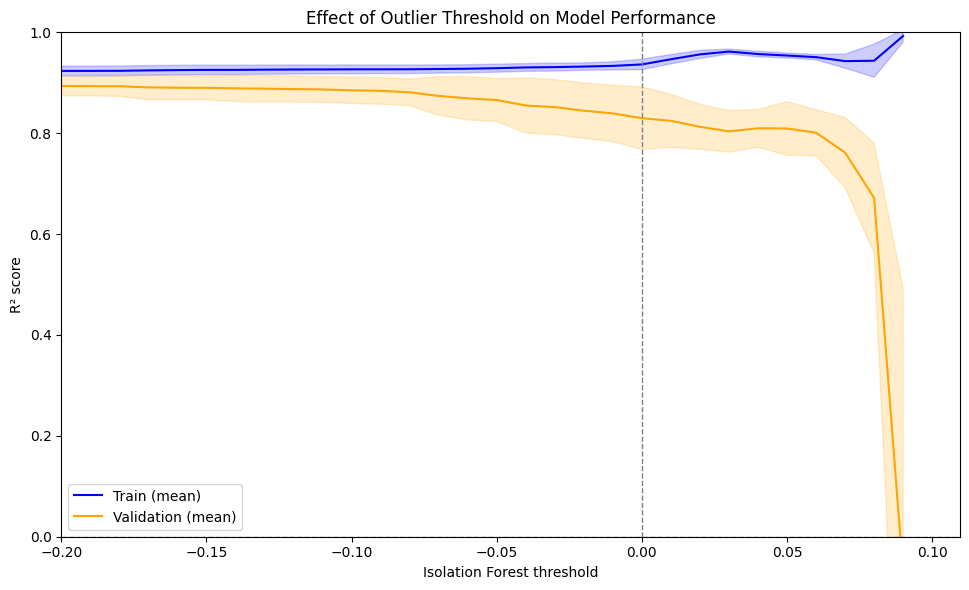

In [79]:

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Average across seeds for each threshold
mean_scores = df_results.groupby("threshold")[["train", "val"]].mean().reset_index()
std_scores = df_results.groupby("threshold")[["train", "val"]].std().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_scores["threshold"], mean_scores["train"], label="Train (mean)", color="blue")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["train"] - std_scores["train"],
                 mean_scores["train"] + std_scores["train"],
                 alpha=0.2, color="blue")

plt.plot(mean_scores["threshold"], mean_scores["val"], label="Validation (mean)", color="orange")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["val"] - std_scores["val"],
                 mean_scores["val"] + std_scores["val"],
                 alpha=0.2, color="orange")

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Isolation Forest threshold")
plt.ylabel("R² score")
plt.title("Effect of Outlier Threshold on Model Performance")
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.xlim(-0.2, None)

(-0.2, 0.10950000000000037)

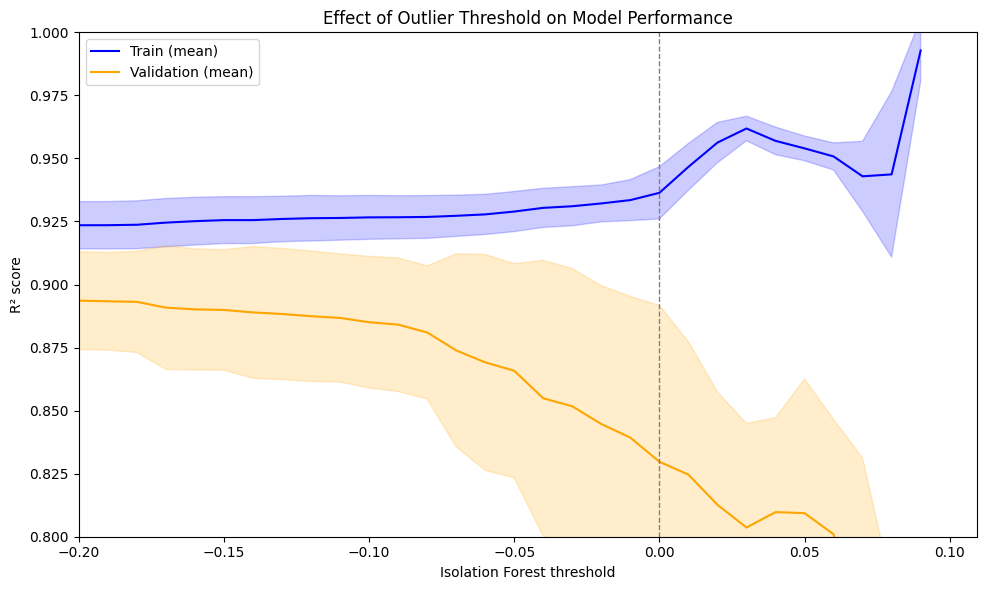

In [ ]:

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Average across seeds for each threshold
mean_scores = df_results.groupby("threshold")[["train", "val"]].mean().reset_index()
std_scores = df_results.groupby("threshold")[["train", "val"]].std().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_scores["threshold"], mean_scores["train"], label="Train (mean)", color="blue")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["train"] - std_scores["train"],
                 mean_scores["train"] + std_scores["train"],
                 alpha=0.2, color="blue")

plt.plot(mean_scores["threshold"], mean_scores["val"], label="Validation (mean)", color="orange")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["val"] - std_scores["val"],
                 mean_scores["val"] + std_scores["val"],
                 alpha=0.2, color="orange")

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Isolation Forest threshold")
plt.ylabel("R² score")
plt.title("Effect of Outlier Threshold on Model Performance")
plt.legend()
plt.tight_layout()
plt.ylim(0.8, 1)
plt.xlim(-0.2, None)

### Filtering the validation data

It might also be interesting to see what would have happend if I also applied the outlier removal on the validation data.

This will of course drastically change the validation by removing the tougher cases. So this will not be a fair comparison anymore!

You could maybe see this as cleaning your validation data to make it "better". But if the real world also contains these outliers, then you are just fooling yourself.

In [33]:
results = []
thresholds = np.arange(-.3, .3, 0.01)

for seed in range(10):
    train, validation = train_test_split(df, test_size=0.25, random_state=seed)  

    train_clean = clean_data(train)
    validation_clean = clean_data(validation)

    X_train, y_train = train_clean[numerical_features + categorical_features], train_clean['Price']
    X_validation, y_validation = validation_clean[numerical_features + categorical_features], validation_clean['Price']

    model = LinearRegression()

    preprocessing = ColumnTransformer(
        transformers=[
            ('cat', Pipeline(steps=[
                ('encoder', TargetEncoder(target_type='continuous', random_state=42)),
            ]), categorical_features),
            ('num', Pipeline(steps=[
                ('scaler', StandardScaler()),
            ]), numerical_features),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('imputing', IterativeImputer(estimator=RandomForestRegressor(max_depth=10), random_state=42))
    ])

    pipeline.fit(X_train, y_train)

    X_train_processed = pipeline.transform(X_train)
    X_validation_processed = pipeline.transform(X_validation)

    iso_forest = IsolationForest(random_state=42)

    iso_forest.fit(X_train_processed)

    scores = iso_forest.decision_function(X_train_processed)
    val_scores = iso_forest.decision_function(X_validation_processed)

    for threshold in thresholds:
        outliers = scores < threshold
        X_train_processed_no_outliers = X_train_processed[~outliers]
        if X_train_processed_no_outliers.shape[0] < 10:
            train_scores.append(np.nan)
            validation_scores.append(np.nan)
            continue
        y_train_no_outliers = y_train[~outliers]

        outliers_validation = val_scores < threshold
        X_validation_no_outliers = X_validation_processed[~outliers_validation]
        y_validation_no_outliers = y_validation[~outliers_validation]

        model = LinearRegression()
        model.fit(X_train_processed_no_outliers, y_train_no_outliers)
        results.append({
            'train': model.score(X_train_processed_no_outliers, y_train_no_outliers),
            'val': model.score(X_validation_no_outliers, y_validation_no_outliers),
            'threshold': threshold,
            'seed': seed
        })

/home/rick/Documents/ai-codex-machine-learning-advanced/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/rick/Documents/ai-codex-machine-learning-advanced/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


(-0.2, 0.1515000000000004)

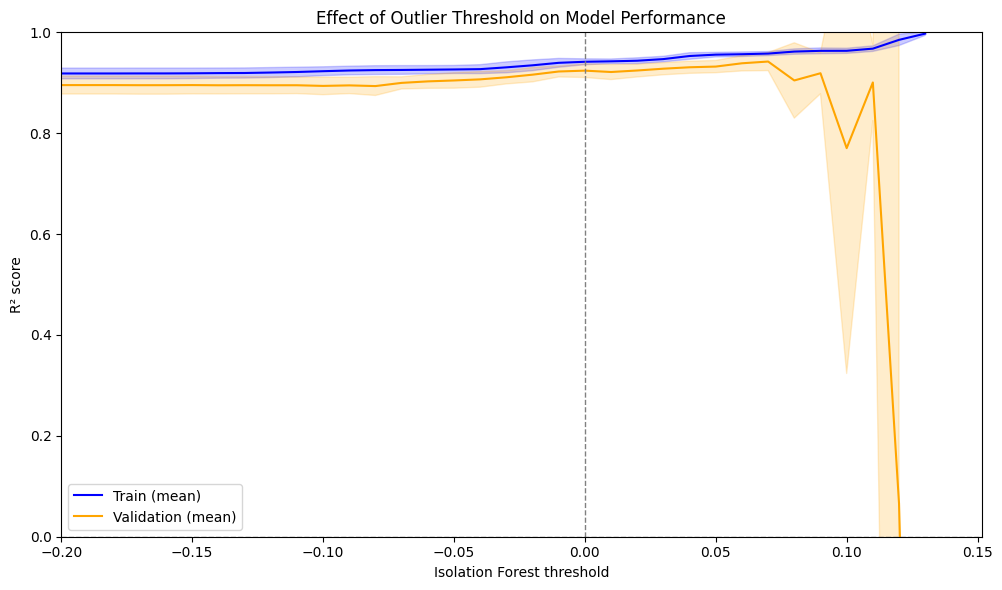

In [34]:

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Average across seeds for each threshold
mean_scores = df_results.groupby("threshold")[["train", "val"]].mean().reset_index()
std_scores = df_results.groupby("threshold")[["train", "val"]].std().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_scores["threshold"], mean_scores["train"], label="Train (mean)", color="blue")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["train"] - std_scores["train"],
                 mean_scores["train"] + std_scores["train"],
                 alpha=0.2, color="blue")

plt.plot(mean_scores["threshold"], mean_scores["val"], label="Validation (mean)", color="orange")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["val"] - std_scores["val"],
                 mean_scores["val"] + std_scores["val"],
                 alpha=0.2, color="orange")

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Isolation Forest threshold")
plt.ylabel("R² score")
plt.title("Effect of Outlier Threshold on Model Performance")
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.xlim(-0.2, None)

(-0.2, 0.1515000000000004)

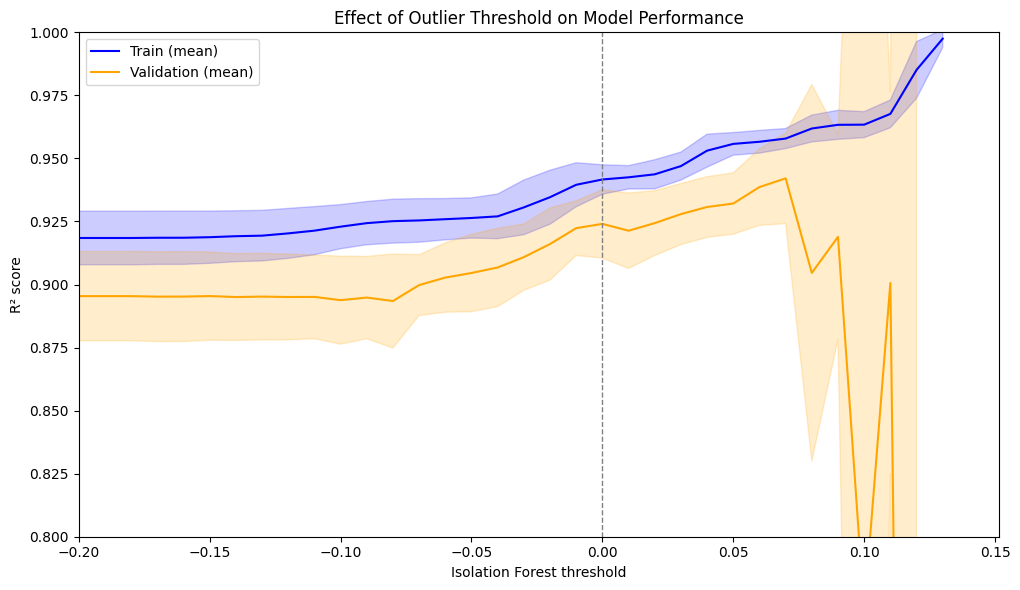

In [35]:

# Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Average across seeds for each threshold
mean_scores = df_results.groupby("threshold")[["train", "val"]].mean().reset_index()
std_scores = df_results.groupby("threshold")[["train", "val"]].std().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.plot(mean_scores["threshold"], mean_scores["train"], label="Train (mean)", color="blue")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["train"] - std_scores["train"],
                 mean_scores["train"] + std_scores["train"],
                 alpha=0.2, color="blue")

plt.plot(mean_scores["threshold"], mean_scores["val"], label="Validation (mean)", color="orange")
plt.fill_between(mean_scores["threshold"],
                 mean_scores["val"] - std_scores["val"],
                 mean_scores["val"] + std_scores["val"],
                 alpha=0.2, color="orange")

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Isolation Forest threshold")
plt.ylabel("R² score")
plt.title("Effect of Outlier Threshold on Model Performance")
plt.legend()
plt.tight_layout()
plt.ylim(0.8, 1)
plt.xlim(-0.2, None)